# The MedNet | Quora Challenge

Investigatory notebook. Quora challenge [here](https://www.kaggle.com/c/quora-question-pairs/overview).

## Data Investigation

Pandas.

In [1]:
import pandas as pd

In [2]:
test_df = pd.read_csv('data/test.csv')
train_df = pd.read_csv('data/train.csv')
sample_df = pd.read_csv('data/sample_submission.csv')

Spark.

In [3]:
from utils.spark import get_or_create_spark
from utils.io import SparkIO
spark = get_or_create_spark()
sio = SparkIO(spark)

In [4]:
spark_test_df = sio.read.csv('data/test.csv')
spark_train_df = sio.read.csv('data/train.csv')
spark_sample_df = sio.read.csv('data/sample_submission.csv')

View negative examples.

In [5]:
sio.display(spark_train_df.where('is_duplicate = 0'), 10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
6,8,17,18,When do you use シ instead of し?,"""When do you use """"&"""" instead of """"and""""?""",0
7,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0
8,10,21,22,Method to find separation of slits using fresn...,What are some of the things technicians can te...,0
9,14,29,30,What are the laws to change your status from a...,What are the laws to change your status from a...,0


View positive examples.

In [6]:
sio.display(spark_train_df.where('is_duplicate = 1'), 10)

,id,qid1,qid2,question1,question2,is_duplicate
0,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
1,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
2,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
3,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
4,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1
5,15,31,32,What would a Trump presidency mean for current...,How will a Trump presidency affect the student...,1
6,16,33,34,What does manipulation mean?,What does manipulation means?,1
7,18,37,38,Why are so many Quora users posting questions ...,Why do people ask Quora questions which can be...,1
8,20,41,42,Why do rockets look white?,Why are rockets and boosters painted white?,1
9,29,59,60,How should I prepare for CA final law?,How one should know that he/she completely pre...,1


Test to see if there are duplicate questions.

In [7]:
from pyspark.sql.functions import collect_list, col, size
# create direction agnostic questions
flipped_df = spark_train_df.selectExpr(
    'question1 as question2', 'question2 as question1'
).select('question1', 'question2')
union_df = spark_train_df.select('question1', 'question2').union(flipped_df)
# group by question
grouped_df = union_df.groupBy('question1').agg(
    size(collect_list(col('question2'))).alias('size')
)
# display summary
sio.display(grouped_df.drop('question1').describe(), 10)

,summary,size
0,count,537377
1,mean,1.5046661840756117
2,stddev,1.9108314556383152
3,min,0
4,max,159


In [8]:
# display top 10 asked questions in the dataset
sio.display(grouped_df.orderBy('size', ascending=False), 10)

,question1,size
0,What are the best ways to lose weight?,159
1,How can you look at someone's private Instagra...,120
2,How can I lose weight quickly?,111
3,What's the easiest way to make money online?,88
4,Can you see who views your Instagram?,79
5,What are some things new employees should know...,77
6,What do you think of the decision by the India...,68
7,Which is the best digital marketing course?,66
8,How can you increase your height?,63
9,How do l see who viewed my videos on Instagram?,61


## Clean & Embed

Clean sentences and create sentence embeddings using the [GloVE](https://nlp.stanford.edu/projects/glove/) vector space.

Spell check and clean.

In [10]:
from typing import List
from keras.preprocessing.text import text_to_word_sequence
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, ArrayType

from nltk.corpus import stopwords
import enchant

try:
    illegal = set(stopwords.words('english'))
except LookupError:
    import nltk
    nltk.download('stopwords')
    illegal = set(nltk.corpus.stopwords.words('english'))
    
word_check = enchant.Dict('en_us')

def split_clean(sentence: str,
                remove_stop_words: bool = False,
                remove_misspells: bool = False) -> List[str]:
    # split the sentence and remove noise
    words = text_to_word_sequence(sentence)
    # remove stop words if viable
    if remove_stop_words:
        words = [word for word in words if word not in illegal]
    # remove misspellings
    if remove_misspells:
        for i, word in enumerate(words):
            # delete word if not recognized
            if not word_check.check(word):
                del words[i]
    # otherwise, replace with closest alternative
    else:
        for i, word in enumerate(words):
            if not word_check.check(word):
                # if suggestions exist, chose most likely
                try:
                    suggestions = word_check.suggest(word)
                    words[i] = suggestions[0].lower()
                # otherwise, remove word
                except:
                    del words[i]
    # return
    return words

split_clean_udf = udf(split_clean, returnType=ArrayType(StringType()))

# drop null values and get clean questions
cleaned_df = spark_train_df.dropna().withColumn(
    'question1_clean', split_clean_udf(col('question1'))
).withColumn(
    'question2_clean', split_clean_udf(col('question2')),
)

sio.display(cleaned_df, 5)

,id,qid1,qid2,question1,question2,is_duplicate,question1_clean,question2_clean
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[what, is, the, story, of, kohinoor, oh, i, no...","[what, would, happen, if, the, indian, governm..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, 23, 24, mat..."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[which, one, dissolve, in, water, quickly, sug...","[which, fish, would, survive, in, salt, water]"


In [140]:
spark_train_df.count()

404301

In [11]:
sio.write.parquet(cleaned_df, 'checkpoints/clean', mode='overwrite')

In [13]:
cleaned_df = sio.read.parquet('checkpoints/clean')
sio.display(cleaned_df, 5)

,id,qid1,qid2,question1,question2,is_duplicate,question1_clean,question2_clean
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[what, is, the, story, of, kohinoor, oh, i, no...","[what, would, happen, if, the, indian, governm..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, 23, 24, mat..."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[which, one, dissolve, in, water, quickly, sug...","[which, fish, would, survive, in, salt, water]"


In [16]:
clean_df = pd.read_parquet('checkpoints/clean')
display(clean_df)

,id,qid1,qid2,question1,question2,is_duplicate,question1_clean,question2_clean
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[what, is, the, story, of, kohinoor, oh, i, no...","[what, would, happen, if, the, indian, governm..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, 23, 24, mat..."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[which, one, dissolve, in, water, quickly, sug...","[which, fish, would, survive, in, salt, water]"
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,"[astrology, i, am, a, capricorn, sun, cap, moo...","[i'm, a, triple, capricorn, sun, moon, and, as..."
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,"[should, i, buy, sago]","[what, keeps, children, active, and, far, from..."
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,"[how, can, i, be, a, good, geologist]","[what, should, i, do, to, be, a, great, geolog..."
8,8,17,18,When do you use シ instead of し?,"""When do you use """"&"""" instead of """"and""""?""",0,"[when, do, you, use, instead, of]","[when, do, you, use, instead, of, and]"
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,"[motorola, company, can, i, hack, my, charter,...","[how, do, i, hack, motorola, for, free, internet]"


Embeddings.

In [21]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = './data/glove.6B.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=3)
print(result)

[('queen', 0.7698541283607483), ('monarch', 0.6843380928039551), ('throne', 0.6755737066268921)]


In [25]:
broadcast_model = spark._sc.broadcast(model)

In [32]:
from pyspark.sql.types import DoubleType
@udf(returnType=ArrayType(ArrayType(DoubleType())))
def glove_encode(sentence_clean: List[str]) -> List[List[float]]:
    encoded_words = []
    for word in sentence_clean:
        try:
            encoded_words.append(broadcast_model.value[word].tolist())
        except:
            pass
    return encoded_words

@udf(returnType=DoubleType())
def glove_distance(sentence1, sentence2):
    return broadcast_model.value.wmdistance(sentence1, sentence2)


encoded_df = cleaned_df.withColumn(
    'question1_encoded', glove_encode(col('question1_clean'))
).withColumn(
    'question2_encoded', glove_encode(col('question2_clean')),
).withColumn(
    'glove_distance', glove_distance(col('question1_clean'), col('question2_clean'))
)
sio.display(encoded_df, 5)

,id,qid1,qid2,question1,question2,is_duplicate,question1_clean,question2_clean,question1_encoded,question2_encoded,glove_distance
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...","[[-0.1518000066280365, 0.38409000635147095, 0....","[[-0.1518000066280365, 0.38409000635147095, 0....",0.756354
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[what, is, the, story, of, kohinoor, oh, i, no...","[what, would, happen, if, the, indian, governm...","[[-0.1518000066280365, 0.38409000635147095, 0....","[[-0.1518000066280365, 0.38409000635147095, 0....",2.617881
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...","[[-0.2376900017261505, 0.5939199924468994, 0.5...","[[-0.2376900017261505, 0.5939199924468994, 0.5...",3.682826
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, 23, 24, mat...","[[0.18449999392032623, 0.5146099925041199, 0.6...","[[-0.13777999579906464, 0.474480003118515, 0.3...",5.787059
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[which, one, dissolve, in, water, quickly, sug...","[which, fish, would, survive, in, salt, water]","[[0.030239999294281006, 0.4460600018501282, 0....","[[0.030239999294281006, 0.4460600018501282, 0....",4.128036


In [38]:
sio.write.parquet(encoded_df.repartition(20), 'checkpoints/encoded', mode='overwrite')

In [5]:
encoded_df = sio.read.parquet('checkpoints/encoded')
sio.display(encoded_df, 10)

,id,qid1,qid2,question1,question2,is_duplicate,question1_clean,question2_clean,question1_encoded,question2_encoded,glove_distance
0,20823,39256,39257,I came to know after 22 years that I am adopte...,I came to know after 28 years that I am adopte...,0,"[i, came, to, know, after, 22, years, that, i,...","[i, came, to, know, after, 28, years, that, i,...","[[-0.046539001166820526, 0.6196600198745728, 0...","[[-0.046539001166820526, 0.6196600198745728, 0...",0.055438
1,61301,107062,107063,Why do siblings fight?,Why do parents fight for silly reasons?,0,"[why, do, siblings, fight]","[why, do, parents, fight, for, silly, reasons]","[[0.18449999392032623, 0.5146099925041199, 0.6...","[[0.18449999392032623, 0.5146099925041199, 0.6...",2.871444
2,59333,103935,6863,Why does time dilation occur?,What is time dilation?,0,"[why, does, time, dilation, occur]","[what, is, time, dilation]","[[0.18449999392032623, 0.5146099925041199, 0.6...","[[-0.1518000066280365, 0.38409000635147095, 0....",2.467726
3,40624,73466,73467,What is the best site to download Hindi music ...,What is the best Hindi song download site with...,0,"[what, is, the, best, site, to, download, hind...","[what, is, the, best, hindi, song, download, s...","[[-0.1518000066280365, 0.38409000635147095, 0....","[[-0.1518000066280365, 0.38409000635147095, 0....",1.934848
4,28207,52327,52328,Why there are so many prejudice upon China on ...,Why is there much prejudice under the topic Ch...,1,"[why, there, are, so, many, prejudice, upon, c...","[why, is, there, much, prejudice, under, the, ...","[[0.18449999392032623, 0.5146099925041199, 0.6...","[[0.18449999392032623, 0.5146099925041199, 0.6...",2.019489
5,2999,5947,5948,How do I hide my IP address?,Is Tor basically the same as software that hid...,0,"[how, do, i, hide, my, pi, address]","[is, tor, basically, the, same, as, software, ...","[[-0.2376900017261505, 0.5939199924468994, 0.5...","[[-0.542639970779419, 0.4147599935531616, 1.03...",4.352140
6,89024,149632,149633,How do I deal with my bf who is romantically c...,How do I deal with a romantically challenged b...,1,"[how, do, i, deal, with, my, bf, who, is, roma...","[how, do, i, deal, with, a, romantically, chal...","[[-0.2376900017261505, 0.5939199924468994, 0.5...","[[-0.2376900017261505, 0.5939199924468994, 0.5...",2.071061
7,88432,148738,148739,What is the future for Thailand?,What is the future of Thailand?,1,"[what, is, the, future, for, thailand]","[what, is, the, future, of, thailand]","[[-0.1518000066280365, 0.38409000635147095, 0....","[[-0.1518000066280365, 0.38409000635147095, 0....",0.713587
8,95466,159211,159212,Is the sentence below grammatically correct?,Are these sentences below phrased grammaticall...,0,"[is, the, sentence, below, grammatically, corr...","[are, these, sentences, below, phrased, gramma...","[[-0.542639970779419, 0.4147599935531616, 1.03...","[[-0.5153300166130066, 0.8318600058555603, 0.2...",2.691034
9,76929,131426,131427,Is there a Scrabble download for Windows 7?,Where can I download Windows 7 Home Basic driv...,0,"[is, there, a, scrabble, download, for, window...","[where, can, i, download, windows, 7, home, ba...","[[-0.542639970779419, 0.4147599935531616, 1.03...","[[0.05104399845004082, 0.5982400178909302, 0.3...",3.550089


Delete broadcast model to save space.

In [58]:
del broadcast_model

Investigate the GloVe sentence distance.

In [6]:
sio.display(encoded_df.where('is_duplicate = 0 and glove_distance < 100').select('glove_distance').describe())

,summary,glove_distance
0,count,253320
1,mean,3.1569653954860035
2,stddev,1.3630133002989249
3,min,0.0
4,max,8.319318739388446


In [7]:
sio.display(encoded_df.where('is_duplicate = 1').select('glove_distance').describe())

,summary,glove_distance
0,count,149131
1,mean,2.142263961198962
2,stddev,0.949357287316955
3,min,0.0
4,max,8.144332496907234


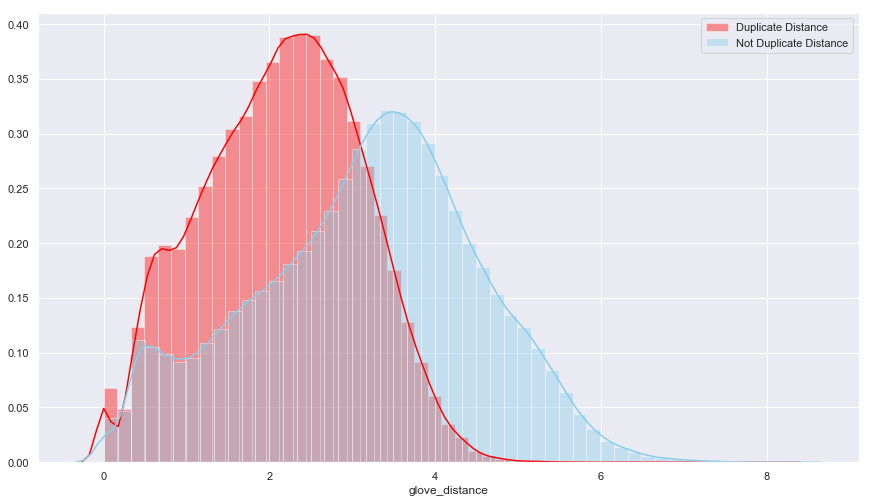

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# duplicate and nodf
pdf = encoded_df.where('is_duplicate = 0 and glove_distance < 100').select('glove_distance')
ndf = encoded_df.where('is_duplicate = 1 and glove_distance < 100').select('glove_distance')
# pandas series
pdf_series = pdf.toPandas()['glove_distance']
ndf_series = ndf.toPandas()['glove_distance']
# seaborn plot
sns.set(rc={'figure.figsize':(14.7,8.27)})
sns.distplot(ndf_series , color="red", label="Duplicate Distance")
sns.distplot(pdf_series , color="skyblue", label="Not Duplicate Distance")
plt.legend()
plt.show()

From this we can see that even a simple `-` operation on the raw GloVe embeddings has valuable information (before ML!).

## Prepare the Data

Load into Pandas.

In [1]:
# pandas_df = encoded_df.select('question1_encoded', 'question2_encoded', 'is_duplicate').toPandas()
import pandas as pd
pandas_df = pd.read_parquet('checkpoints/encoded')

In [2]:
# drop infinite glove distance values
# and invalid is_duplicate values --> this should occur
# at the cleaning stage.
pandas_df = pandas_df[pandas_df['glove_distance'] < float('inf')]
pandas_df = pandas_df[pandas_df['is_duplicate'].isin(['0', '1'])]
pandas_df['is_duplicate'] = pd.to_numeric(pandas_df['is_duplicate'])

In [ ]:
pandas_df.info()

In [8]:
display(pandas_df.head(100))

,id,qid1,qid2,question1,question2,is_duplicate,question1_clean,question2_clean,question1_encoded,question2_encoded,glove_distance
0,67622,116998,116999,How is the food at IIT Madras?,How is the food at IIT Madras hostels? Are the...,1,"[how, is, the, food, at, it, madras]","[how, is, the, food, at, it, madras, hostels, ...","[[-0.2376900017261505, 0.5939199924468994, 0.5...","[[-0.2376900017261505, 0.5939199924468994, 0.5...",2.642437
1,26316,48991,48992,What do white people in America mean when they...,Americans say that everyone wants to come here...,0,"[what, do, white, people, in, america, mean, w...","[americans, say, that, everyone, wants, to, co...","[[-0.1518000066280365, 0.38409000635147095, 0....","[[0.2055100053548813, 1.00409996509552, 0.6659...",3.508002
2,28235,52376,52377,What web browser do Vizio smart TVs have?,Does the Vizio Smart TV have a web browser?,0,"[what, web, browser, do, vizier, smart, vs, have]","[does, the, vizier, smart, tv, have, a, web, b...","[[-0.1518000066280365, 0.38409000635147095, 0....","[[-0.09340199828147888, 0.5560200214385986, 0....",2.342002
3,67475,116762,116763,Why do women fake orgasm?,Do women fake orgasms?,0,"[why, do, women, fake, orgasm]","[do, women, fake, orgasms]","[[0.18449999392032623, 0.5146099925041199, 0.6...","[[-0.1704699993133545, 0.40369999408721924, 0....",1.937681
4,97337,161971,161972,How do I stop eating and start working and exe...,How can I stop eating and start exercising suc...,1,"[how, do, i, stop, eating, and, start, working...","[how, can, i, stop, eating, and, start, exerci...","[[-0.2376900017261505, 0.5939199924468994, 0.5...","[[-0.2376900017261505, 0.5939199924468994, 0.5...",1.324960
5,87452,147290,147291,Is there any evidence to prove the existence o...,How does the supernatural power or God exists?,0,"[is, there, any, evidence, to, prove, the, exi...","[how, does, the, supernatural, power, or, god,...","[[-0.542639970779419, 0.4147599935531616, 1.03...","[[-0.2376900017261505, 0.5939199924468994, 0.5...",4.049010
6,10192,19778,19779,What are the most iconic songs associated with...,Why does the Vietnam War have more cool songs ...,0,"[what, are, the, most, iconic, songs, associat...","[why, does, the, vietnam, war, have, more, coo...","[[-0.1518000066280365, 0.38409000635147095, 0....","[[0.18449999392032623, 0.5146099925041199, 0.6...",2.793053
7,21237,40009,40010,Should I sell my Xbox One and Buy a PS4?,Should I buy a PS4 or an Xbox one?,0,"[should, i, sell, my, box, one, and, buy, a, psi]","[should, i, buy, a, psi, or, an, box, one]","[[-0.04473700001835823, 0.4751499891281128, 0....","[[-0.04473700001835823, 0.4751499891281128, 0....",1.611515
8,96094,160125,160126,How can I apply at uber?,How can I re apply to uber?,0,"[how, can, i, apply, at, tuber]","[how, can, i, re, apply, to, tuber]","[[-0.2376900017261505, 0.5939199924468994, 0.5...","[[-0.2376900017261505, 0.5939199924468994, 0.5...",1.617498
9,46560,83269,83270,How can I be sure that my boyfriend is cheatin...,How sure are you that your boyfriend is not ch...,0,"[how, can, i, be, sure, that, my, boyfriend, i...","[how, sure, are, you, that, your, boyfriend, i...","[[-0.2376900017261505, 0.5939199924468994, 0.5...","[[-0.2376900017261505, 0.5939199924468994, 0.5...",1.287617


In [3]:
# stack the vectors
import numpy as np

q1e = pandas_df['question1_encoded'].apply(lambda x: np.stack(x, axis=0))
q2e = pandas_df['question2_encoded'].apply(lambda x: np.stack(x, axis=0))
is_duplicate = pandas_df['is_duplicate']

Zero-pad.

In [4]:
max_len = max(q1e.map(len).max(), q2e.map(len).max())
max_len_pad = ((max_len // 50) + 1) * 50 
print(f'Maximum encoded length is {max_len}.')
print(f'Pad to a length of {max_len_pad}.')

Maximum encoded length is 226.
Pad to a length of 250.


In [5]:
from keras.preprocessing import sequence
X_train_q1_pad = sequence.pad_sequences(q1e, dtype=np.float32, maxlen=50)
X_train_q2_pad = sequence.pad_sequences(q2e, dtype=np.float32, maxlen=50)

Using TensorFlow backend.


Train-validation split!

In [6]:
from sklearn.model_selection import train_test_split
# split
split = train_test_split(X_train_q1_pad, X_train_q2_pad, is_duplicate, test_size=0.2)
# unpack
q1_train, q1_test, q2_train, q2_test, Y_train, Y_test = split

Look at the class imbalance. (This should be re-balanced via up / down sampling.)

In [30]:
positive_cnt = is_duplicate[is_duplicate == 1].count()
negative_cnt = is_duplicate[is_duplicate == 0].count()
print(f'Num positives: {positive_cnt}, num negatives: {negative_cnt}, positive pct: {(positive_cnt / (is_duplicate.count()))*100.}')

Num positives: 149131, num negatives: 253318, positive pct: 37.05587540284607


## Create Model & Train

In [7]:
input_shape = q1_train.shape[1:]
print('Input shape:', input_shape)
print('Target shape:', Y_train.shape)

Input shape: (50, 100)
Target shape: (321959,)


Use a shared LSTM with a final dense layer. Inspiration from [here](https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models).

In [44]:
import keras
from keras.layers import Input, LSTM, Dense, concatenate, CuDNNLSTM, Dropout
from keras.models import Model

# define inputs
input_q1 = Input(shape=input_shape)
input_q2 = Input(shape=input_shape)

# multi-LSTM model.
# match the number of hidden layers in the LSTM cell with
# the size of the embedding layer output from GloVe.
lstm_input = Input(shape=input_shape)
#lstm1 = CuDNNLSTM(100, return_sequences=True)(lstm_input)
#dropout1 = Dropout(0.2)(lstm1)
#lstm2 = CuDNNLSTM(100)(dropout1)
#dropout2 = Dropout(0.2)(lstm2)
lstm = CuDNNLSTM(100)(lstm_input)
dropout = Dropout(0.2)(lstm)
lstm_model = Model(lstm_input, dropout)


# Reuse the same layer instance. 
# The same weights are used for both questions.
encoded_q1 = lstm_model(input_q1)
encoded_q2 = lstm_model(input_q2)

# We can then concatenate the two vectors:
merged = concatenate([encoded_q1, encoded_q2], axis=-1)

# And add a logistic regression on top

dense1 = Dense(100, activation='relu')(merged)
dropout3 = Dropout(0.1)(dense1)
dense2 = Dense(1, activation='sigmoid')(dropout3)

# We define a trainable model linking the
# tweet inputs to the predictions
model = Model(inputs=[input_q1, input_q2], outputs=dense2)

In [45]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 50, 100)      0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           (None, 50, 100)      0                                            
__________________________________________________________________________________________________
model_12 (Model)                (None, 100)          80800       input_25[0][0]                   
                                                                 input_26[0][0]                   
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 200)          0           model_12[1][0]                   
          

In [18]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
# callback to stop when overfitting is seen
from keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

In [20]:
model.fit(x=[q1_train, q2_train], y=Y_train, epochs=100,
          validation_data=([q1_test, q2_test], Y_test),
          callbacks=callbacks)

Train on 321959 samples, validate on 80490 samples
Epoch 1/100
321959/321959 [==============================] - 603s 2ms/step - loss: 0.5091 - acc: 0.7413 - val_loss: 0.4557 - val_acc: 0.7777
Epoch 2/100
321959/321959 [==============================] - 616s 2ms/step - loss: 0.4441 - acc: 0.7848 - val_loss: 0.4292 - val_acc: 0.7945
Epoch 3/100
321959/321959 [==============================] - 615s 2ms/step - loss: 0.4160 - acc: 0.8009 - val_loss: 0.4152 - val_acc: 0.8040
Epoch 4/100
321959/321959 [==============================] - 605s 2ms/step - loss: 0.3965 - acc: 0.8118 - val_loss: 0.4039 - val_acc: 0.8108
Epoch 5/100
321959/321959 [==============================] - 613s 2ms/step - loss: 0.3801 - acc: 0.8219 - val_loss: 0.4043 - val_acc: 0.8088
Epoch 6/100
321959/321959 [==============================] - 612s 2ms/step - loss: 0.3656 - acc: 0.8290 - val_loss: 0.3981 - val_acc: 0.8161
Epoch 7/100
321959/321959 [==============================] - 602s 2ms/step - loss: 0.3558 - acc: 0.8351

In [21]:
model.save('model.h5')

In [23]:
import pickle
with open('./train_history', 'wb') as file_pi:
    pickle.dump(Out[20].history, file_pi)

## Obtain Test Results

In [40]:
from keras.models import load_model
model = load_model('model.h5')

In [41]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 50, 100)      0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 50, 100)      0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 100)          80800       input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 200)          0           model_3[1][0]                    
          

Load in test data.

In [1]:
from utils.spark import get_or_create_spark
from utils.io import SparkIO
spark = get_or_create_spark()
sio = SparkIO(spark)

In [2]:
test_df = sio.read.csv('data/test.csv')
sample_df = sio.read.csv('data/sample_submission.csv')

In [3]:
sio.display(test_df, 5)

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"""How """"aberystwyth"""" start reading?""",How their can I start reading?


In [4]:
sio.display(sample_df, 5)

,test_id,is_duplicate
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


Clean data.

In [45]:
from typing import List
from keras.preprocessing.text import text_to_word_sequence
from pyspark.sql.functions import udf, col, pandas_udf
from pyspark.sql.types import StringType, ArrayType

from nltk.corpus import stopwords
import enchant

try:
    illegal = set(stopwords.words('english'))
except LookupError:
    import nltk
    nltk.download('stopwords')
    illegal = set(nltk.corpus.stopwords.words('english'))
    
word_check = enchant.Dict('en_us')

# broad cast word check
bword_check = spark._sc.broadcast(word_check)
billegal = spark._sc.broadcast(illegal)

def split_clean(sentence: str,
                remove_stop_words: bool = False,
                remove_misspells: bool = False) -> List[str]:
    # tap into broadcast
    #word_check = bword_check.value
    #illegal = billegal.value
    # split the sentence and remove noise
    try:
        words = text_to_word_sequence(sentence)
        return words
    except:
        return None
    # remove stop words if viable
    #if remove_stop_words:
    #    words = [word for word in words if word not in illegal]
    # remove misspellings
    #if remove_misspells:
    #    for i, word in enumerate(words):
    #        # delete word if not recognized
    #        if not word_check.check(word):
    #            del words[i]
    # otherwise, replace with closest alternative
    #else:
    def safe_check(word):
        if word_check.check(word):
            return word
        else:
            suggested = word_check.suggest(word)
            if suggested:
                return suggested[0]
            return None
        
        
        #for i, word in enumerate(words):
        #    if not word_check.check(word):
        #        # if suggestions exist, chose most likely
        #        try:
        #            suggestions = word_check.suggest(word)
        #            words[i] = suggestions[0].lower()
        #        # otherwise, remove word
        #        except:
        #            del words[i]
    # return
    words = [safe_check(word) for word in words]
    words = [word for word in words if word]
    return '|'.join(words)

#@pandas_udf(returnType=ArrayType(StringType()))
#def split_clean_udf(sentence_series):
#    return sentence_series.apply(split_clean)

#split_clean_udf = udf(split_clean, returnType=ArrayType(StringType()))
split_clean_udf = udf(split_clean)

# drop null values and get clean questions
cleaned_df = test_df.withColumn(
    'question1_clean', split_clean_udf(col('question1'))
).withColumn(
    'question2_clean', split_clean_udf(col('question2')),
)

sio.display(cleaned_df, 5)

,test_id,question1,question2,question1_clean,question2_clean
0,345169,Is Obama a Muslim or a Christian?,Why do people incorrectly think President Obam...,"[is, obama, a, muslim, or, a, christian]","[why, do, people, incorrectly, think, presiden..."
1,552269,What ways can you earn yourself fifteen dollar...,What ways can you earn seventy five dollars on...,"[what, ways, can, you, earn, yourself, fifteen...","[what, ways, can, you, earn, seventy, five, do..."
2,152484,How do I change my okay username?,I want to change suicide username on Instagram...,"[how, do, i, change, my, okay, username]","[i, want, to, change, suicide, username, on, i..."
3,485305,What has changed in the central government off...,What has the Modi government achieved since co...,"[what, has, changed, in, the, central, governm...","[what, has, the, modi, government, achieved, s..."
4,574736,How can I pass the 70-461 saliva exam?,How do I pass c# 70-461 without studying?,"[how, can, i, pass, the, 70, 461, saliva, exam]","[how, do, i, pass, c, 70, 461, without, studying]"
